In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np

# Sys
import warnings
# Keras Core
import tensorflow as tf
from keras.layers.convolutional import MaxPooling2D, Convolution2D, AveragePooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Input, Dropout, Dense, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization
from keras.layers.merge import concatenate
from keras.layers import Add
from keras import regularizers
from keras import initializers
from keras.models import Model
from keras import optimizers
from keras import callbacks
import math
from keras_preprocessing.image import ImageDataGenerator

# Backend
from keras import backend as K


In [ ]:
aug = ImageDataGenerator(
                         samplewise_center=True,
                         samplewise_std_normalization=True)
bs = 16
train_path = '/content/drive/MyDrive/TDS/Data Set/Training Dataset'
valid_path = '/content/drive/MyDrive/TDS/Data Set/Validation Dataset'

train_generator = aug.flow_from_directory(
    train_path,
    target_size=(256, 256),
    batch_size=bs) # set as training data

validation_generator = aug.flow_from_directory(
    '/content/drive/MyDrive/TDS/Data Set/Validation Dataset', # same directory as training data
    target_size=(256, 256),
    batch_size=bs) # set as validation data

Found 6000 images belonging to 10 classes.
Found 3000 images belonging to 10 classes.


In [ ]:
# Change this according to your dataset
image_size = 256
no_classes = 10

In [ ]:
# Convolution 2D with batch norm
def conv2d_bn(x, nb_filter, num_row, num_col,
            padding='same', strides=(1, 1), use_bias=False):
  """
  Utility function to apply conv + BN. 
  (Slightly modified from https://github.com/fchollet/keras/blob/master/keras/applications/inception_v3.py)
  """
  if K.image_data_format() == 'channels_first':
    channel_axis = 1
  else:
    channel_axis = -1
  x = Convolution2D(nb_filter, (num_row, num_col),
                    strides=strides,
                    padding=padding,
                    use_bias=use_bias,
                    kernel_regularizer=regularizers.l2(0.00004),
                    kernel_initializer=initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None))(x)
  x = BatchNormalization(axis=channel_axis, momentum=0.9997, scale=False)(x)
  x = Activation('relu')(x)
  return x

# Recurrent convolutional layer
def RCL(input, kernel_size, filedepth):
  if K.image_data_format() == 'channels_first':
    channel_axis = 1
  else:
    channel_axis = -1

  conv1 = Convolution2D(filters=filedepth, kernel_size=kernel_size, strides=(1, 1), padding='same',
                 kernel_regularizer=regularizers.l2(0.00004),
                 kernel_initializer=initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None))(input)

  stack2 = BatchNormalization(axis=channel_axis, momentum=0.9997, scale=False)(conv1)
  stack2 = Activation('relu')(stack2)

  RCL = Convolution2D(filters=filedepth, kernel_size=kernel_size, strides=(1, 1), padding='same', 
                 kernel_regularizer=regularizers.l2(0.00004),
                 kernel_initializer=initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None))

  conv2 = RCL(stack2)
  stack3 = Add()([conv1, conv2])
  stack4 = BatchNormalization(axis=channel_axis, momentum=0.9997, scale=False)(stack3)
  stack4 = Activation('relu')(stack4)


  conv3 = Convolution2D(filters=filedepth, kernel_size=kernel_size, strides=(1, 1), padding='same',
                 weights=RCL.get_weights(),
                 kernel_regularizer=regularizers.l2(0.00004),
                 kernel_initializer=initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None))(stack4)
  stack5 = Add()([conv1, conv3])
  stack6 = BatchNormalization(axis=channel_axis, momentum=0.9997, scale=False)(stack5)
  stack6 = Activation('relu')(stack6)


  conv4 = Convolution2D(filters=filedepth, kernel_size=kernel_size, strides=(1, 1), padding='same',
                 weights=RCL.get_weights(),
                 kernel_regularizer=regularizers.l2(0.00004),
                 kernel_initializer=initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None))(stack6)
  stack7 = Add()([conv1, conv4])
  stack8 = BatchNormalization(axis=channel_axis, momentum=0.9997, scale=False)(stack7)
  stack8 = Activation('relu')(stack8)

  return stack8


def IRCNN_block(input):
  if K.image_data_format() == 'channels_first':
    channel_axis = 1
  else:
    channel_axis = -1

  branch_0 = RCL(input, (1, 1), 64)

  branch_1 = RCL(input, (3, 3), 128)

  branch_2 = AveragePooling2D((3,3), strides=(1,1), padding='same')(input)
  branch_2 = RCL(branch_2, (1, 1), 64)

  x = concatenate([branch_0, branch_1, branch_2], axis=channel_axis)
  return x

In [ ]:
def IRCNN_base(input):

  if K.image_data_format() == 'channels_first':
#     inputShape = (3, 256, 256)
    channel_axis = 1
  else:
#     inputShape = (256, 256, 3)
    channel_axis = -1

  # Input Shape is 3 x 256 x 256
  net = Convolution2D(32, (3, 3), strides=(2,2), padding='valid')(input)
  net = conv2d_bn(net, 32, 3, 3, padding='valid')
  net = conv2d_bn(net, 64, 3, 3)

  net = IRCNN_block(input)
                 
  net = conv2d_bn(net, 32, 3, 3, strides=(2,2), padding='valid')
  net = MaxPooling2D((3,3), strides=(2,2), padding='valid')(net)
  net = Dropout(0.5)(net)

  net = IRCNN_block(input)
                 
  net = conv2d_bn(net, 32, 3, 3, strides=(2,2), padding='valid')
  net = MaxPooling2D((3,3), strides=(2,2), padding='valid')(net)
  net = Dropout(0.5)(net)
                 
  net = IRCNN_block(input)
                 
  net = conv2d_bn(net, 32, 3, 3, strides=(2,2), padding='valid')
  net = GlobalAveragePooling2D()(net)
  net = Dropout(0.5)(net)
  
  
  return net			

In [ ]:
if K.image_data_format() == 'channels_first':
  inputs = Input(shape = (3, image_size, image_size))
else:
  inputs = Input(shape = (image_size, image_size, 3))

# x = Convolution2D(32, (3, 3), strides=(2,2), padding='valid')(inputs)
x = IRCNN_base(inputs)
x = Dense(units=no_classes, activation='softmax')(x)

model = Model(inputs, x, name='IRCNN')

In [ ]:
model.summary()

Model: "IRCNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 average_pooling2d_2 (AveragePo  (None, 256, 256, 3)  0          ['input_1[0][0]']                
 oling2D)                                                                                         
                                                                                                  
 conv2d_29 (Conv2D)             (None, 256, 256, 64  256         ['input_1[0][0]']                
                                )                                                             

In [ ]:
# adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
sgd = tf.keras.optimizers.SGD(lr=0.01)

#filepath="./weights-{epoch:02d}-{val_acc:.2f}.hdf5"

#mcp = callbacks.ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#callbacks_list = [mcp]

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
train_step=train_generator.n//train_generator.batch_size
valid_step=validation_generator.n//validation_generator.batch_size

In [ ]:
history=model.fit_generator(
    train_generator,
    steps_per_epoch=train_step,
    validation_data=validation_generator,
    validation_steps=valid_step,
    epochs=50,
    #callbacks=callbacks_list,
    verbose=1
    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
375/375 [==============================] - 1576s 4s/step - loss: 1.9970 - accuracy: 0.3080 - val_loss: 3.0573 - val_accuracy: 0.0999
Epoch 2/50
375/375 [==============================] - 196s 524ms/step - loss: 1.6929 - accuracy: 0.4200 - val_loss: 4.4342 - val_accuracy: 0.1003
Epoch 3/50
375/375 [==============================] - 196s 523ms/step - loss: 1.5286 - accuracy: 0.4883 - val_loss: 3.8260 - val_accuracy: 0.0999
Epoch 4/50
375/375 [==============================] - 196s 523ms/step - loss: 1.4368 - accuracy: 0.4955 - val_loss: 2.9639 - val_accuracy: 0.1003
Epoch 5/50
375/375 [==============================] - 196s 523ms/step - loss: 1.3678 - accuracy: 0.5315 - val_loss: 2.3650 - val_accuracy: 0.1357
Epoch 6/50
375/375 [==============================] - 196s 523ms/step - loss: 1.3021 - accuracy: 0.5492 - val_loss: 2.3299 - val_accuracy: 0.1845
Epoch 7/50
375/375 [==============================] - 196s 523ms/step - loss: 1.2625 - accuracy: 0.5600 - val_loss: 1.9852 - v

In [ ]:
import matplotlib.pyplot as plt
IMG_SIZE = 256 
epochs=50

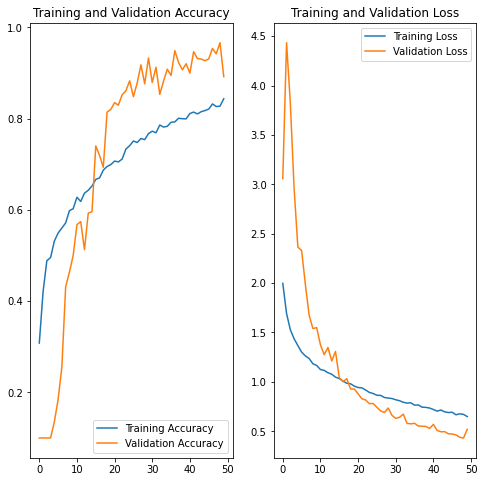

In [ ]:
acc = history.history['accuracy']
val_acc =history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/ saved_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ saved_model/assets


In [ ]:
test_generator = aug.flow_from_directory(
    '/content/drive/MyDrive/TDS/Data Set/Testing Dataset', # same directory as training data
    target_size=(256, 256),
    batch_size=bs)

Found 2000 images belonging to 10 classes.


In [ ]:
from tensorflow import keras
new_model = keras.models.load_model('/content/drive/MyDrive/ saved_model')

In [ ]:
 # You can also evaluate or predict on a dataset.
print("Evaluate")
result = new_model.evaluate(test_generator)
dict(zip(new_model.metrics_names, result))

Evaluate
125/125 [==============================] - 367s 3s/step - loss: 0.5389 - accuracy: 0.9005


{'accuracy': 0.9004999995231628, 'loss': 0.5389176607131958}